In [28]:
import os
import re
import json
import torch
import pprint
import random
import stamina
import logging
import warnings
import tempfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from typing import cast
from einops import rearrange
from qdrant_client.http import models
from qdrant_client import QdrantClient
from pdf2image import convert_from_path
from huggingface_hub import notebook_login
from datasets import Dataset, load_dataset
from qwen_vl_utils import process_vision_info
from IPython.display import display, Markdown
from vidore_benchmark.utils.image_utils import scale_image
from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from vidore_benchmark.interpretability.vit_configs import VIT_CONFIG
from vidore_benchmark.interpretability.plot_utils import plot_similarity_heatmap
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from vidore_benchmark.interpretability.torch_utils import (normalize_similarity_map_per_query_token, )

warnings.simplefilter('ignore')
notebook_login(new_session=False)

User is already logged in.


In [18]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
wd = os.path.dirname(os.getcwd())
os.chdir(wd)
print(f'path: {wd}') 

path: /home/dgarieck23/VLMs/tunnel_vision


In [3]:
from src.utils.utils import *

### Helpers

### Leveraging GPU for Perfomance
To optimize performance, we'll use GPU accelaration if available

In [4]:
device = get_device()

GPU is available
GPU name: NVIDIA GeForce RTX 4090 Laptop GPU


#### Set Seed
To enhance reproductibility, and comparatibility

In [5]:
seed = 42
random.seed(seed)              # Python's built-in random module
np.random.seed(seed)           # NumPy
torch.manual_seed(seed)        # PyTorch
torch.cuda.manual_seed(seed)   # For GPU computations in PyTorch
torch.cuda.manual_seed_all(seed)  # If you're using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Pdf to Image

Performs a batch conversion of PDF files into images. It reads the files from a specified directory, converts each page into an image, and saves the resulting images in a temporary folder. Saving the images into a temporary folder will help us to avoid weird [bugs](https://github.com/huggingface/datasets/issues/4796) loading the dataset for fine-tuning using the library datasets from Hugging Face

In [6]:
temp_dir = tempfile.mkdtemp()
file = 'data/raw/Blackstone4Q23EPR.pdf'

images = convert_from_path(file, dpi=150, thread_count=6)

In [7]:
# save each image with a unique name in the temporary directory
filename = re.split('/',file.replace('.pdf',''))[0]

for idx, img in enumerate(images):
    img_filename = f"{filename}_page_{idx + 1}.png"
    img.save(os.path.join(temp_dir, img_filename))

print(f'Images saved in temporary folder: {temp_dir}')

Images saved in temporary folder: /tmp/tmpc99r00un


Load the images saved in the temporary directory as a dataset, using the load_dataset function from the Hugging Face datasets library. The dataset is structured in an image folder format, where each image file is treated as an individual data point.

In [8]:
dataset = load_dataset('imagefolder', data_dir=temp_dir, split='train')

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

For many real-world document collections, we often have metadata associated with the documents, which can be indexed in a database. These data points typically include fields such as title, author, date, type of document, and more. Metadata plays a crucial role during search and retrieval tasks, as it allows for more structured and precise filtering, improving the overall effectiveness of finding relevant information within large document sets.

### Indexing the dataset

The Qdrant Python client provides a convenient way to interact with a Qdrant database, offering an in-memory implementation that is perfect for testing and experimentation. While this feature isn’t suitable for production environments, it allows for quick prototyping without the need to configure a persistent database. This makes it easy to dive straight into the code and start working with your dataset right away.

In [10]:
# ":memory:" for in-memory database or "path/to/db" for persistent storage
qdrant_client = QdrantClient(
    ":memory:"
)

### Setting up the ColPali model

In [31]:
model_name = 'vidore/colpali-v1.2'

# load the model
model = cast(
    ColPali,
    ColPali.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
).eval()

# load the processor
processor = cast(ColPaliProcessor, ColPaliProcessor.from_pretrained(model_name))

# load the ViT config
vit_config = VIT_CONFIG[model.config.name_or_path]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Using multivectors and Qdrant

In order to use multivectors in Qdrant, we need to specify the dimension of the vectors. So, in order to use it, we need to specify their length.

In [12]:
sample_image = dataset[0]['image']
with torch.no_grad():
    sample_batch = processor.process_images([sample_image]).to(model.device)
    sample_embedding = model(**sample_batch)

In [13]:
sample_embedding

tensor([[[-0.0244, -0.0457, -0.0457,  ...,  0.0449, -0.0250,  0.1299],
         [-0.1357, -0.0510,  0.1943,  ...,  0.0243,  0.0264, -0.0713],
         [-0.2139, -0.0038,  0.1865,  ...,  0.0479,  0.0454, -0.0344],
         ...,
         [-0.0825,  0.0732,  0.2109,  ..., -0.0388,  0.0250, -0.0261],
         [-0.0515, -0.0130,  0.1650,  ...,  0.0393,  0.0095, -0.1240],
         [-0.1089, -0.0347,  0.0099,  ...,  0.0396,  0.0068, -0.1245]]],
       device='cuda:0', dtype=torch.bfloat16)

In [14]:
# check the length of the vectors by looking at the last dimension of the tensor.
size = sample_embedding.shape[-1]

When creating a collection in Qdrant, some important parameters must be defined. 
- `size` specifies the size of the vectors to be stored.
- `distance` specifies the similarity metric used to compare them.
- `distance` informs Qdrant that the collection will store multivectors rather than traditional single vectors.

To optimize the memory usage when working with large-scale embeddings, we can apply some for of quantization. Scalar quantization is a technique that reduces the precision of the values in the embeddings, converting them from higher-precision types (like `float32` or `float16`) into smaller types such as `INT8`. By converting embeddings into `INT8`, the size of the vectors is significantly reduced, lowering the memory footprint while maintaining acceptable accuracy for many tasks.

Other option could be binary quantization:
```python
quantization_config = models.BinaryQuantization(
    binary=models.BinaryQuantizationConfig(
        always_ram=True,
    )
)
```


In [15]:
collection_name = 'earnings_release'

qdrant_client.recreate_collection(
    collection_name=collection_name,  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=100
    ),  # could be useful to switch this off when doing a bulk upload and then manually trigger the indexing once the upload is done
    vectors_config=models.VectorParams(
        size=size,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.ScalarQuantization(
            scalar=models.ScalarQuantizationConfig(
                type=models.ScalarType.INT8,
                quantile=0.99,
                always_ram=True,
            ),
        ),
    ),
)

True

If you had the indexing off during the upload you can trigger an index by setting a lower indexing threshold.

```python
qdrant_client.update_collection(
    collection_name=collection_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
)
```

In [16]:
@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(points):
    qdrant_client.upsert(
        collection_name=collection_name,
        points=points,
        wait=False,
    )

In [19]:
batch_size = 6  # adjust based on your GPU memory constraints

In [20]:
with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i: i + batch_size]

        # the images are already PIL Image objects, so we can use them directly
        images = batch["image"]

        # process and encode images
        with torch.no_grad():
            batch_images = processor.process_images(images).to(model.device)
            image_embeddings = model(**batch_images)

        # prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(
                models.PointStruct(
                    id=i + j,
                    vector=multivector,
                    payload={
                        'source': 'internet archive',
                        'author': 'blackstone',
                        'type': 'earnings release',
                        'year': '2023',                        
                        'quarter': 'q4',
                        'symbol': 'NYSE:BX',                                                                                                
                        },
                )
            )

        # upload points to Qdrant
        try:
            upsert_to_qdrant(points)
        except Exception as e:
            logger.error(f"Error during upsert: {e}")
            continue

        # update the progress bar
        pbar.update(len(batch))

logger.info("Indexing complete!")

Indexing Progress: 48it [31:10, 38.96s/it]                        
INFO:__main__:Indexing complete!


### Searching our dataset

In [21]:
query_text = 'financial measures highlights'
with torch.no_grad():
    batch_query = processor.process_queries([query_text]).to(model.device)
    query_embedding = model(**batch_query)

In [22]:
# convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [23]:
# search in Qdrant
search_result = qdrant_client.query_points(
    collection_name=collection_name, query=multivector_query, limit=10, timeout=60
)

search_result.points

[ScoredPoint(id=39, version=0, score=14.759503355511129, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=31, version=0, score=12.885732846669487, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=34, version=0, score=12.439399121412277, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=35, version=0, score=12.43514607313004, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=28, version=0, score=12.207549186398692, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=11, version=0, score=12.160823683111554, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=6, version=0, score=12.08264862569089, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_v

In [46]:
idx = search_result.points[0].id
image = dataset[idx]['image']

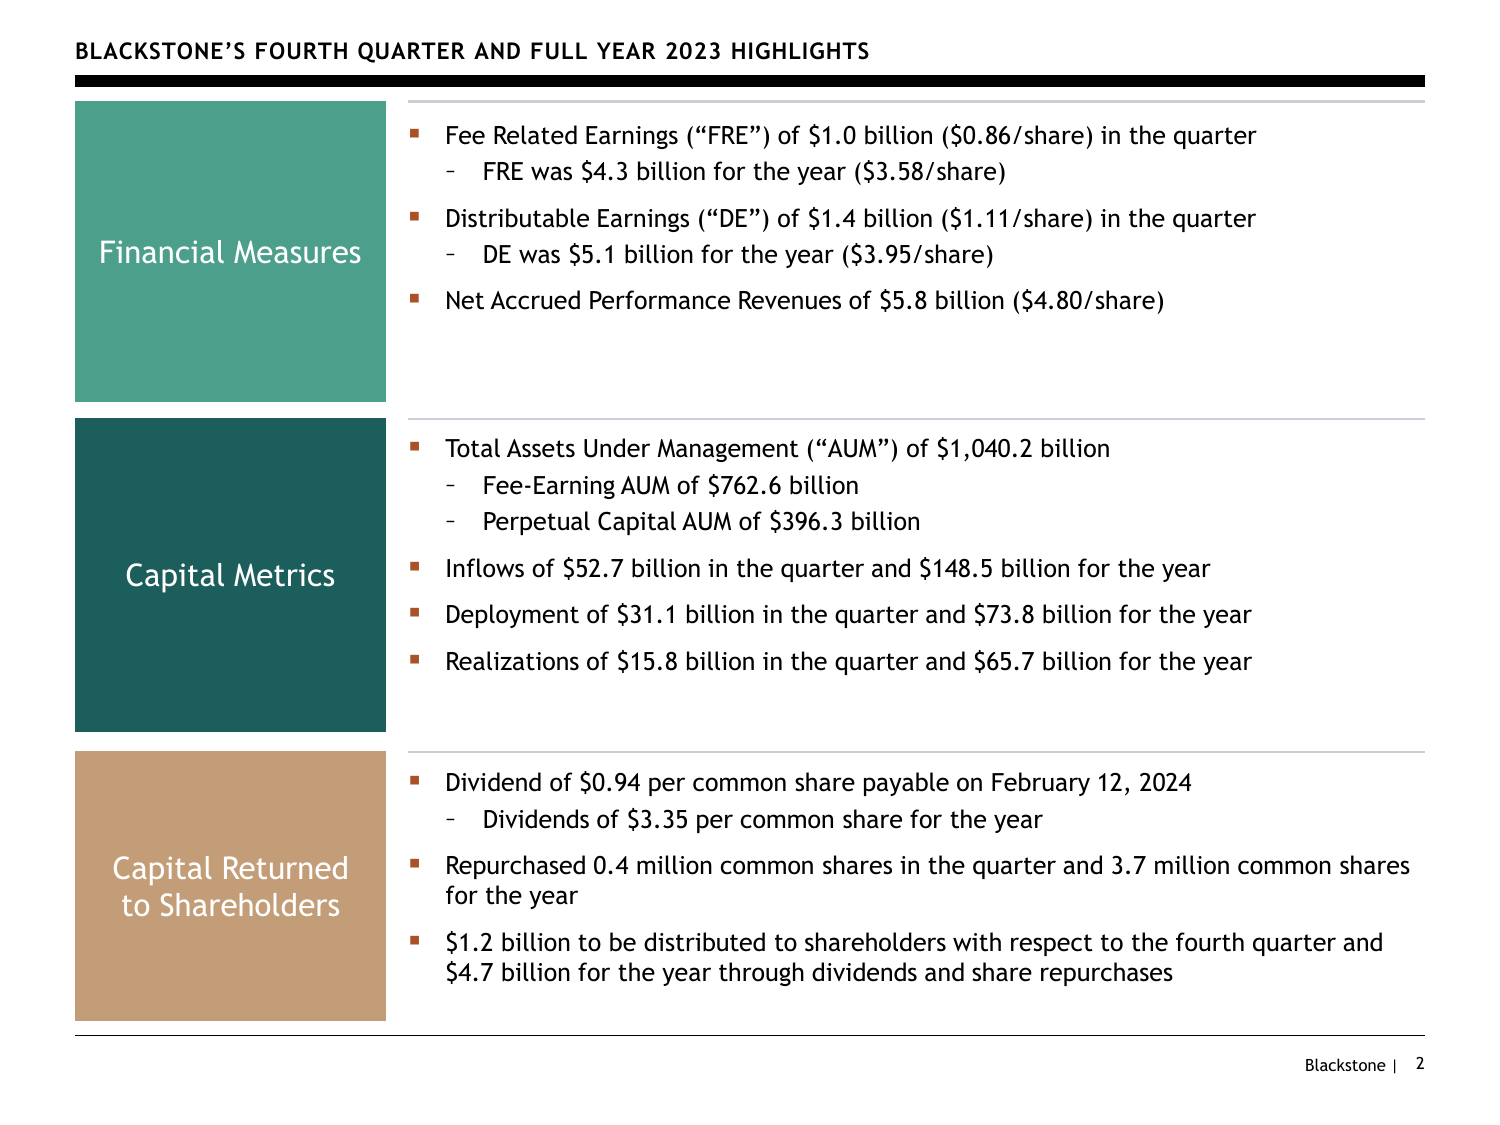

In [47]:
image

### Similarity maps

In [32]:
# preprocess inputs
input_text_processed = processor.process_queries([query_text]).to(device)
input_image_processed = processor.process_images([dataset[idx]['image']]).to(device)

# forward passes
with torch.no_grad():
    output_text = model.forward(**input_text_processed)
    output_image = model.forward(**input_image_processed)

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


In [33]:
# remove the special tokens from the output
output_image = output_image[:, : processor.image_seq_length, :]  # (1, n_patches_x * n_patches_y, dim)

# rearrange the output image tensor to explicitly represent the 2D grid of patches
output_image = rearrange(
    output_image, "b (h w) c -> b h w c", h=vit_config.n_patch_per_dim, w=vit_config.n_patch_per_dim
)  # (1, n_patches_x, n_patches_y, dim)

In [34]:
# get the similarity map
similarity_map = torch.einsum(
    "bnk,bijk->bnij", output_text, output_image
)  # (1, query_tokens, n_patches_x, n_patches_y)

# normalize the similarity map
similarity_map_normalized = normalize_similarity_map_per_query_token(
    similarity_map
)  # (1, query_tokens, n_patches_x, n_patches_y)

In [35]:
# use this cell output to choose a token using its index
query_tokens = processor.tokenizer.tokenize(processor.decode(input_text_processed.input_ids[0]))

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Question',
 2: ':',
 3: '▁financial',
 4: '▁measures',
 5: '▁highlights',
 6: '<pad>',
 7: '<pad>',
 8: '<pad>',
 9: '<pad>',
 10: '<pad>',
 11: '<pad>',
 12: '<pad>',
 13: '<pad>',
 14: '<pad>',
 15: '<pad>',
 16: '\n'}


In [50]:
# retrieve the similarity map for the chosen token
token_idx = [3,4,5]
current_similarity_map = similarity_map_normalized[0, token_idx, :, :].mean(dim=0)

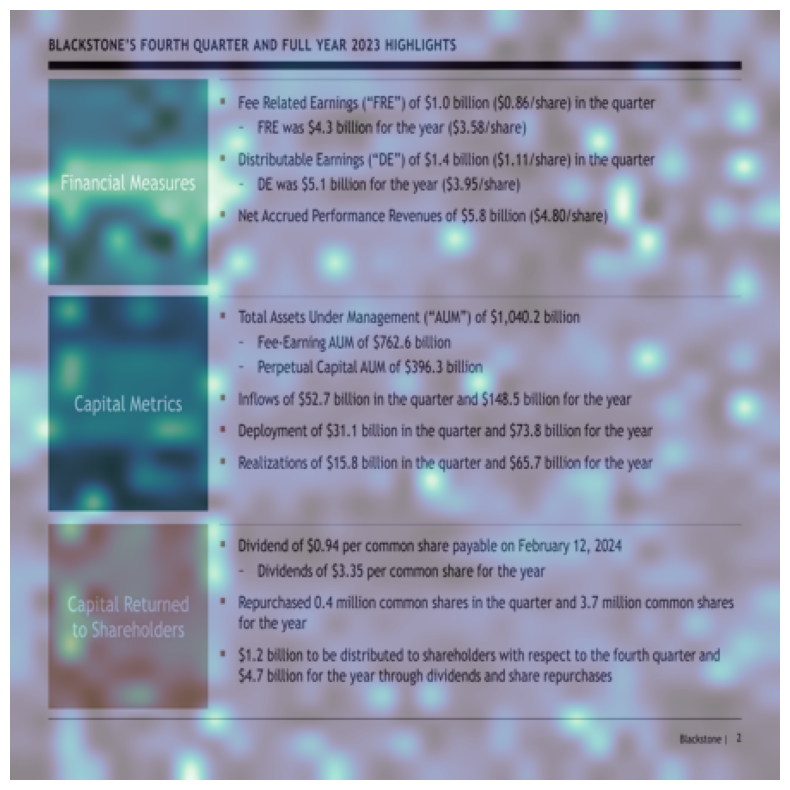

In [52]:
# Resize the image to square
input_image_square = image.resize((vit_config.resolution, vit_config.resolution))

attention_map_image = Image.fromarray(
    (similarity_map_normalized[0, token_idx, :, :].mean(dim=0).to(torch.float32).cpu().numpy() * 255).astype("uint8")
).resize(input_image_square.size, Image.Resampling.BICUBIC)

# Plot the similarity map
fig, ax = plot_similarity_heatmap(
    input_image_square,
    patch_size=vit_config.patch_size,
    image_resolution=vit_config.resolution,
    similarity_map=similarity_map_normalized[0, token_idx, :, :].mean(dim=0),
)

In [53]:
# to avoid OOM errors in the next part I'm removing components for ColPali
clear_gpu([model,processor])
clear_gpu([])

### Augmented Generation

In [55]:
vl_model = 'Qwen/Qwen2-VL-2B-Instruct'

In [56]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    vl_model, 
    trust_remote_code=True, 
    torch_dtype=torch.bfloat16,
    attn_implementation='flash_attention_2',
    device_map=device
).eval()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [65]:
processor = AutoProcessor.from_pretrained(vl_model, trust_remote_code=True)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": input_image_square},
            {"type": "text", "text": query_text + '\n as a specialized assitant make sense out of the information given'},
        ],
    }
]

In [66]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [67]:
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors='pt',
)
inputs = inputs.to(device)

In [68]:
generated_ids = model.generate(**inputs, max_new_tokens=150)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [69]:
display(Markdown(output_text[0]))

Certainly! Here is a breakdown of the financial measures and capital metrics for Blackstone's fourth quarter and full year 2023 highlights:

### Financial Measures Highlights
- **Fee Related Earnings (\"FRE\"):** $1.0 billion ($0.86/share) in the quarter
  - FRE was $4.3 billion for the year ($3.58/share)
- **Distributable Earnings (\"DE\"):** $1.4 billion ($1.11/share) in the quarter
  - DE was $5.1 billion for the year ($3.95/share)
- **Net Accrued Performance Revenues:** $5.8 billion ($4.80